# Large Turbine Wind Speed and Power Predictions
**Author:** Ian Eykamp, **Date:** July 26, 2023

## Purpose
To give an estimate of the voltage and power that will be generated by the large wind turbine during operation on Olin's campus. This will be useful for speccing a dump load resistor, which is done at the end of this document.

## Estimates Based On Secondary Sources
### Dylan's OneDrive
Dylan Merzenich and Anna Letcher Hartman worked on the mechanical side of the turbine, designing a 6-foot tower for the turbine to sit on. Their work is consolidated [here](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx) (you will need OneDrive permission): [https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx).

On page 3 of this [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E2%20Aerodynamic%20load%20analysis%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources), there is a table linking wind speed to generator revolutions per minute. This is tabulated using Pandas in the script below.

![Eastern Wind Power wind speed vs. generator revolutions per minute table](eastern_wind_power_wind_speed_rpm.png)

On page 31 of this [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources&ga=1), the design parameters are listed. This suggests that at 20m/s wind speed, the generator will be rotating at 215rpm, at which point the pneumatic brakes will be applied. This is the cut-out generator speed; we do not need to handle any speeds much higher than this.

![Eastern Wind Power design parameters table](eastern_wind_power_parameters_table.png)

Page 15 of the same [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources&ga=1) has a graph of power output vs. wind speed. This matches the data tabulated in the script below from an extended version of the same document (accessed as a hard copy from the Eastern Wind Power binders in Chhavi's lab).

![Eastern Wind Power wind speed vs. generator power (measured)](eastern_wind_power_wind_speed_power_measured.png)

The graph on Page 13 seems to be a slight overestimate compared to the measured values on p.15, and it suggests that the power output at 15m/s wind speed is just short of 25kW, or at 20m/s, the power output is 50kW.

![Eastern Wind Power wind speed vs. generator power (theoretical)](eastern_wind_power_wind_speed_power_theoretical.png)

Slide 10 of Dylan and Anna's [presentation](https://olincollege-my.sharepoint.com/:p:/r/personal/dmerzenich_olin_edu/_layouts/15/Doc.aspx?sourcedoc=%7B0CB9372D-7ADA-405B-8642-884E389CB85F%7D&file=Final%20Presentation.pptx&action=edit&mobileredirect=true) suggests having a cut-out wind speed of 15m/s. Above this speed, we would program the Arduino to enable the pneumatic brakes, or at least disconnect the batteries from the generator and connect the dump load.

### Conclusions Based On Secondary Sources
If we use 20m/s as the cut-out speed, we should be able to handle 50kW of dump load power, with the turbine spinning at 225rpm. If we use 15m/s as the cut-out speed, the maximum power becomes under 25kW, and the rotations speed is closer to 180rpm. I would advocate for using 15m/s as our cut-out speed, just to make the power and voltages (let alone the kinetic energy of the turbine!) a little less scary.

## Primary Source: Anemometer Data
I have data from an anemometer (wind speed measuring device) that has been active around campus for about a year (since sometime in the Fall 2022 semester when JEH ran as a class). The anemometer was moved several times, but the wind speed data was not significantly different.

To view and download the anemometer data, go to this [link](https://zentracloud.com/accounts/login/?next=/), and login with the following information. Long link: [https://zentracloud.com/accounts/login/?next=/](https://zentracloud.com/accounts/login/?next=/)

![Zentra anemometer login information. Username: lvanasupa@olin.edu, Password: JustEnergyHub1](zentra_login.png)

The website shows the wind speed averaged to every few hours, as well as "gust speed," which I think means the maximum wind speed during each averaging time block. You can also download the minutely data and do the averaging yourself, as I have done below.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: <object object at 0x00000274218CE4F0>


### Load anemometer data

In [2]:
data_file_path = "z6-20340(z6-20340)-Configuration 1-1689879751.4027638.csv"
cols_on_which_to_parse_dates = ['Timestamps']
df = pd.read_csv(data_file_path, skiprows = 2, parse_dates = cols_on_which_to_parse_dates)
# print(df.columns)

df_downsampled_unagreggated = df.set_index("Timestamps")[" m/s Wind Speed"].resample("D")

### Resample data
By resampling the data myself, I can perform multiple aggregation methods, such as finding the max, min, various percentiles, and mean for each averaged bin of data. Here, I am averaging the data daily. To change to hourly, for example, change the `resample("D")` line in the above code chunk to `resample("H")`.

In [3]:
df_downsampled = pd.DataFrame()
df_downsampled["max"] = df_downsampled_unagreggated.max()
df_downsampled["min"] = df_downsampled_unagreggated.min()
df_downsampled["90_percentile"] = df_downsampled_unagreggated.quantile(0.9)
df_downsampled["10_percentile"] = df_downsampled_unagreggated.quantile(0.1)
df_downsampled["median"] = df_downsampled_unagreggated.quantile(0.5)
df_downsampled["sd"] = df_downsampled_unagreggated.std()
df_downsampled["mean"] = df_downsampled_unagreggated.mean()
# print(df_downsampled.head(3))

### Plot Data

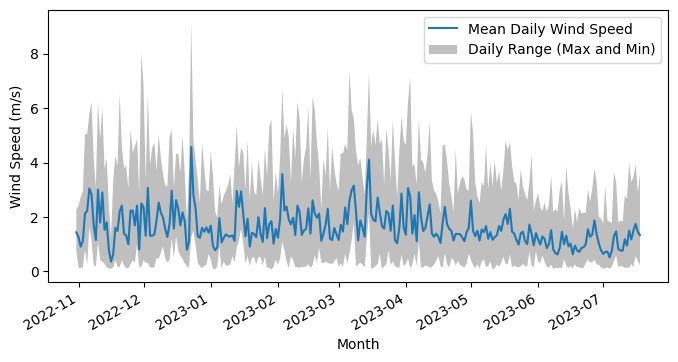

In [4]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, sharey = False, figsize = (8, 4))
ax1.plot(df_downsampled.index, df_downsampled["mean"], linestyle = "solid", label = "Mean Daily Wind Speed")
ax1.fill_between(df_downsampled.index, df_downsampled["max"], df_downsampled["min"], facecolor='gray', alpha=0.5, label = "Daily Range (Max and Min)")
fig.autofmt_xdate()
ax1.set_xlabel("Month")
ax1.set_ylabel("Wind Speed (m/s)")
ax1.legend()

According to the anemometer data, the average wind speed on Olin's campus is around 2m/s, which is below the realistic cut-in wind speed for the rotor to even spin. But consider that each data point in the above graph represents an entire day---any time the blue line peaks above 3m/s or 4m/s, that means the wind was blowing that strongly consistently for the entire day. More realistically, the wind will blow somewhere in the gray region for an hour or two out of the day---enough to get the turbine up to speed and keep it there for enough time to generate real power. Even still, most of the time the maximum wind speed is below 6m/s, and only once in the last year did it get to 9m/s.

In reality, nearly every day, the rotor will stay below 100rpm, maybe reaching 70rpm for an hour every couple days. In terms of power, this is no more than 4-6kW even on the windiest days.

If we care about limiting our dump load resistor to 15kW capacity, we can set the cut-out wind speed to be even lower, say 12m/s. In a whole year of wind speed data, we never would have had to shut down, even at this threshold. And if we know the brakes will come on at any higher wind speeds, we can save a lot of money on making our dump load less beefy.

## Dump Load Resistors
We can configure three beefy resistors in a delta configuration to act as a three-phase dump load. The power rating of the dump load will be the sum of the power ratings of the three resistors. The highest power dissipating resistor available on the market is 5kW and comes from Digikey for $400, Amazon for $150, or various resellers on Ebay for around $100 apiece. Three 5kW resistors would give us 15kW of dump load power capacity. Increasing our cut-out speed to 20m/s would increase this to 30kW, meaning we would have to buy six resistors, and it would double the price.

## PLECS Model

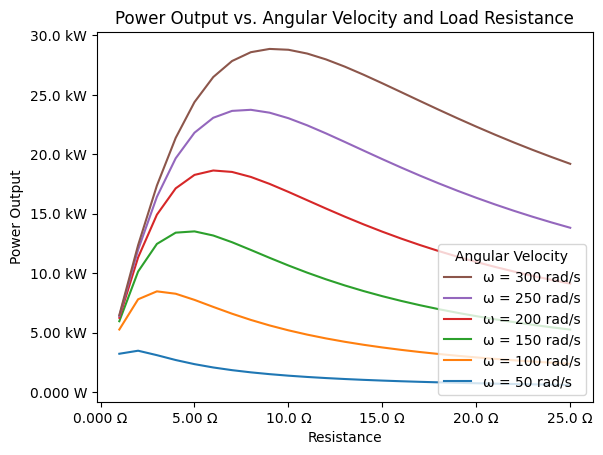

In [74]:
def get_params(param_str):
    resistance = float(param_str.partition("RL = ")[2].partition("ohms")[0])
    angular_velocity = float(param_str.partition("wr = ")[2].partition("rad/s")[0])
    power = float(param_str.partition("power = ")[2].partition("W")[0])
    return resistance, angular_velocity, power

df_plecs = pd.DataFrame(columns = ["Resistance (ohms)", "Angular Velocity (rad/s)", "Power (W)"])
with open("plecs/plecs_parameter_sweep_2.txt") as file:
    for line in file:
        if line.startswith("Kt") or line.startswith("Imax") or line.strip() == "":
            continue
        resistance, angular_velocity, power = get_params(line)
        df_plecs.loc[len(df_plecs)] = ([resistance, angular_velocity, power])

# print(df_plecs)

grouped = df_plecs.groupby("Angular Velocity (rad/s)")

fig, ax1 = plt.subplots()
helper.axes_labels("Resistance", "Ω", "Power Output", "W", title = "Power Output vs. Angular Velocity and Load Resistance")
for name, group in grouped:
    plt.plot(group["Resistance (ohms)"], group["Power (W)"], label = f"ω = {name:.0f} rad/s")
# plt.legend(loc = "lower right")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(labels), title = "Angular Velocity", loc='lower right')

In [5]:
df_rotor_speed = pd.DataFrame(
    columns = ["Load Case #", "Wind Speed (m/s)", "Rotor Speed (rpm)", "Rotor Speed (rad/s)", "Tip Speed Ratio (TSR)"], 
    data = [
        [1,  2,  23,  2.4,  3.0],
        [2,  4,  46,  4.8,  3.0],
        [3,  6,  69,  7.2,  3.0],
        [4,  8,  92,  9.6,  3.0],
        [5,  10, 115, 12.0, 3.0],
        [6,  12, 138, 14.5, 3.0],
        [7,  14, 160, 16.8, 3.0],
        [8,  16, 183, 19.2, 3.0],
        [9,  18, 206, 21.6, 3.0],
        [10, 20, 229, 24.0, 3.0],
        [11, 22, 252, 26.4, 3.0],
    ]
).set_index("Load Case #")
print(df_rotor_speed)

             Wind Speed (m/s)  Rotor Speed (rpm)  Rotor Speed (rad/s)  \
Load Case #                                                             
1                           2                 23                  2.4   
2                           4                 46                  4.8   
3                           6                 69                  7.2   
4                           8                 92                  9.6   
5                          10                115                 12.0   
6                          12                138                 14.5   
7                          14                160                 16.8   
8                          16                183                 19.2   
9                          18                206                 21.6   
10                         20                229                 24.0   
11                         22                252                 26.4   

             Tip Speed Ratio (TSR)  
Load Case #  

In [6]:
df_generator_power = pd.DataFrame(
    columns = ["Wind Speed Bin (m/s)", "Power Output (kW)"], 
    data = [
        [0.5,  0.00],
        [1.0,  0.00],
        [1.5,  0.00],
        [2.0,  0.00],
        [2.5,  0.00],
        [3.0,  0.00],
        [3.5,  0.00],
        [4.0,  0.19],
        [4.5,  0.33],
        [5.0,  0.51],
        [5.5,  0.71],
        [6.0,  1.00],
        [6.5,  1.38],
        [7.0,  1.74],
        [7.5,  2.27],
        [8.0,  2.58],
        [8.5,  3.23],
        [9.0,  4.04],
        [9.5,  4.67],
        [10.0, 5.41],
        [10.5, 6.59],
        [11.0, 7.58],
        [11.5, 9.18],
        [12.0, 9.40],
        [12.5, 10.20],
        [13.0, 10.82],
        [13.5, 13.01],
        [14.0, 13.01],
        [14.5, 13.01],
        [15.0, 13.01],
    ]
)
print(df_generator_power)

    Wind Speed Bin (m/s)  Power Output (kW)
0                    0.5               0.00
1                    1.0               0.00
2                    1.5               0.00
3                    2.0               0.00
4                    2.5               0.00
5                    3.0               0.00
6                    3.5               0.00
7                    4.0               0.19
8                    4.5               0.33
9                    5.0               0.51
10                   5.5               0.71
11                   6.0               1.00
12                   6.5               1.38
13                   7.0               1.74
14                   7.5               2.27
15                   8.0               2.58
16                   8.5               3.23
17                   9.0               4.04
18                   9.5               4.67
19                  10.0               5.41
20                  10.5               6.59
21                  11.0        